# Model Training Pipeline

Training models using the engineered features from Sprint 2 (02_Feature_Engineering.ipynb)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Load Engineered Features

Loading the features created in `02_Feature_Engineering.ipynb`

In [2]:
X_train_full = pd.read_csv('output/train_features_engineered.csv')
y_train_full = pd.read_csv('output/train_target.csv').squeeze()
X_test = pd.read_csv('output/test_features_engineered.csv')

print(f"  Training features: {X_train_full.shape}")
print(f"  Training target: {y_train_full.shape}")
print(f"  Test features: {X_test.shape}")
print(f"\n  Features: {X_train_full.shape[1]}")
print(f"  Training samples: {X_train_full.shape[0]:,}")
print(f"  Test samples: {X_test.shape[0]:,}")

  Training features: (100820, 45)
  Training target: (100820,)
  Test features: (44726, 46)

  Features: 45
  Training samples: 100,820
  Test samples: 44,726


## 2. Train/Validation Split

In [3]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print("Data split:")
print(f"  Training: {X_train.shape[0]:,} samples")
print(f"  Validation: {X_val.shape[0]:,} samples")
print(f"  Test: {X_test.shape[0]:,} samples")

Data split:
  Training: 80,656 samples
  Validation: 20,164 samples
  Test: 44,726 samples


## 3. Preprocess Features

In [4]:
# Handle categorical features
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Identify feature types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")
if categorical_features:
    print(f"  Categorical: {categorical_features}")

# Create preprocessor
transformers = []
if numeric_features:
    transformers.append(('scaler', StandardScaler(), numeric_features))
if categorical_features:
    transformers.append(('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_features))

if transformers:
    preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
    
    # Fit and transform
    X_train_proc = preprocessor.fit_transform(X_train)
    X_val_proc = preprocessor.transform(X_val)
    X_test_proc = preprocessor.transform(X_test)
    
    print(f"\n✓ Preprocessing complete")
    print(f"  Final feature count: {X_train_proc.shape[1]}")
else:
    X_train_proc = X_train.values
    X_val_proc = X_val.values
    X_test_proc = X_test.values
    print("\n✓ No preprocessing needed")

Numeric features: 41
Categorical features: 3
  Categorical: ['performance_category', 'time_category', 'lexicon_category']

✓ Preprocessing complete
  Final feature count: 52


## 4. Train Models

### 4.1 Random Forest

In [5]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf.fit(X_train_proc, y_train)

# Evaluate
y_pred_train = rf.predict(X_train_proc)
y_pred_val = rf.predict(X_val_proc)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)
train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
val_mae = mean_absolute_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)
val_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100

print(f"\nTraining Metrics:")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  MAE:  {train_mae:.2f}")
print(f"  MAPE: {train_mape:.2f}%")
print(f"  R²:   {train_r2:.4f}")

print(f"\nValidation Metrics:")
print(f"  RMSE: {val_rmse:.2f}")
print(f"  MAE:  {val_mae:.2f}")
print(f"  MAPE: {val_mape:.2f}%")
print(f"  R²:   {val_r2:.4f}")

rf_results = {'model': 'RandomForest', 'train_rmse': train_rmse, 'train_r2': train_r2,
              'val_rmse': val_rmse, 'val_r2': val_r2, 'val_mape': val_mape}


Training Metrics:
  RMSE: 56.29
  MAE:  37.93
  MAPE: 2.02%
  R²:   0.9411

Validation Metrics:
  RMSE: 92.75
  MAE:  62.11
  MAPE: 3.35%
  R²:   0.8394


### 4.2 XGBoost

In [6]:
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
xgb_model.fit(X_train_proc, y_train)

# Evaluate
y_pred_train = xgb_model.predict(X_train_proc)
y_pred_val = xgb_model.predict(X_val_proc)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)
train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
val_mae = mean_absolute_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)
val_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100

print(f"\nTraining Metrics:")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  MAE:  {train_mae:.2f}")
print(f"  MAPE: {train_mape:.2f}%")
print(f"  R²:   {train_r2:.4f}")

print(f"\nValidation Metrics:")
print(f"  RMSE: {val_rmse:.2f}")
print(f"  MAE:  {val_mae:.2f}")
print(f"  MAPE: {val_mape:.2f}%")
print(f"  R²:   {val_r2:.4f}")

xgb_results = {'model': 'XGBoost', 'train_rmse': train_rmse, 'train_r2': train_r2,
               'val_rmse': val_rmse, 'val_r2': val_r2, 'val_mape': val_mape}


Training Metrics:
  RMSE: 94.55
  MAE:  67.19
  MAPE: 3.63%
  R²:   0.8337

Validation Metrics:
  RMSE: 98.22
  MAE:  68.99
  MAPE: 3.73%
  R²:   0.8199


## 5. Hyperparameter Tuning

**Observations from baseline models:**
- RandomForest: High overfitting (train_rmse=56.29 vs val_rmse=92.75) → needs regularization
- XGBoost: Small train/val gap (train_rmse=94.55 vs val_rmse=98.22) → can train longer

**Strategy:**
- RandomForest: Reduce overfitting with max_depth, min_samples constraints, and max_features
- XGBoost: Increase capacity with more estimators, early stopping, and tuned learning rate


### 5.1 Random Forest Hyperparameter Tuning


In [7]:
# Fast manual tuning approach - test key parameters individually
import time

print("Random Forest Fast Tuning (Manual Grid)")
print("=" * 60)
print("Testing focused parameter combinations to reduce overfitting...\n")

# Test configurations focusing on reducing overfitting
configs = [
    # Baseline
    {'name': 'Baseline', 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 
     'max_features': 'sqrt', 'n_estimators': 100, 'max_samples': None},
    
    # Limit depth
    {'name': 'Limited_Depth', 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2, 
     'max_features': 'sqrt', 'n_estimators': 100, 'max_samples': None},
    
    # Increase leaf requirements
    {'name': 'More_Leaf_Samples', 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 5, 
     'max_features': 'sqrt', 'n_estimators': 100, 'max_samples': None},
    
    # Limit features + bootstrap samples
    {'name': 'Limited_Features', 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 5, 
     'max_features': 0.5, 'n_estimators': 100, 'max_samples': 0.8},
    
    # More trees with regularization
    {'name': 'More_Trees_Reg', 'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 5, 
     'max_features': 0.5, 'n_estimators': 200, 'max_samples': 0.8},
    
    # Aggressive regularization
    {'name': 'Strong_Reg', 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 8, 
     'max_features': 0.4, 'n_estimators': 200, 'max_samples': 0.7},
]

results = []
for config in configs:
    start = time.time()
    name = config.pop('name')
    
    # Train model
    rf_test = RandomForestRegressor(random_state=42, n_jobs=-1, **config)
    rf_test.fit(X_train_proc, y_train)
    
    # Evaluate
    train_pred = rf_test.predict(X_train_proc)
    val_pred = rf_test.predict(X_val_proc)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    gap = val_rmse - train_rmse
    
    elapsed = time.time() - start
    
    results.append({
        'config': name,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'gap': gap,
        'time': elapsed,
        'params': config
    })
    
    print(f"{name:20s} | Train: {train_rmse:6.2f} | Val: {val_rmse:6.2f} | Gap: {gap:6.2f} | {elapsed:.1f}s")

# Find best configuration
results_df = pd.DataFrame(results)
best_idx = results_df['val_rmse'].idxmin()
best_config = results_df.iloc[best_idx]

print(f"\n{'='*60}")
print(f"Best Configuration: {best_config['config']}")
print(f"  Val RMSE: {best_config['val_rmse']:.2f}")
print(f"  Gap: {best_config['gap']:.2f}")
print(f"\nBest parameters:")
for param, value in best_config['params'].items():
    print(f"  {param}: {value}")


Random Forest Fast Tuning (Manual Grid)
Testing focused parameter combinations to reduce overfitting...



Baseline             | Train:  62.51 | Val:  96.83 | Gap:  34.32 | 3.1s
Limited_Depth        | Train:  79.11 | Val:  97.47 | Gap:  18.35 | 2.5s
More_Leaf_Samples    | Train:  83.66 | Val:  98.36 | Gap:  14.70 | 2.5s
Limited_Features     | Train:  79.50 | Val:  94.27 | Gap:  14.77 | 6.9s
More_Trees_Reg       | Train:  88.67 | Val:  96.17 | Gap:   7.50 | 12.1s
Strong_Reg           | Train:  96.04 | Val:  99.99 | Gap:   3.94 | 7.7s

Best Configuration: Limited_Features
  Val RMSE: 94.27
  Gap: 14.77

Best parameters:
  max_depth: 15
  min_samples_split: 10
  min_samples_leaf: 5
  max_features: 0.5
  n_estimators: 100
  max_samples: 0.8


In [8]:
# Train best Random Forest model
rf_tuned = RandomForestRegressor(random_state=42, n_jobs=-1, **best_config['params'])
rf_tuned.fit(X_train_proc, y_train)

y_pred_train_rf = rf_tuned.predict(X_train_proc)
y_pred_val_rf = rf_tuned.predict(X_val_proc)

train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
train_mae_rf = mean_absolute_error(y_train, y_pred_train_rf)
train_r2_rf = r2_score(y_train, y_pred_train_rf)
train_mape_rf = np.mean(np.abs((y_train - y_pred_train_rf) / y_train)) * 100

val_rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_val_rf))
val_mae_rf = mean_absolute_error(y_val, y_pred_val_rf)
val_r2_rf = r2_score(y_val, y_pred_val_rf)
val_mape_rf = np.mean(np.abs((y_val - y_pred_val_rf) / y_val)) * 100

print(f"\n{'='*60}")
print(f"TUNED RANDOM FOREST PERFORMANCE")
print(f"{'='*60}")
print(f"\nTraining Metrics:")
print(f"  RMSE: {train_rmse_rf:.2f}")
print(f"  MAE:  {train_mae_rf:.2f}")
print(f"  MAPE: {train_mape_rf:.2f}%")
print(f"  R²:   {train_r2_rf:.4f}")

print(f"\nValidation Metrics:")
print(f"  RMSE: {val_rmse_rf:.2f}")
print(f"  MAE:  {val_mae_rf:.2f}")
print(f"  MAPE: {val_mape_rf:.2f}%")
print(f"  R²:   {val_r2_rf:.4f}")

print(f"\nOverfitting Gap (Train-Val RMSE): {val_rmse_rf - train_rmse_rf:.2f}")

rf_tuned_results = {
    'model': 'RandomForest_Tuned',
    'train_rmse': train_rmse_rf,
    'train_r2': train_r2_rf,
    'val_rmse': val_rmse_rf,
    'val_r2': val_r2_rf,
    'val_mape': val_mape_rf
}



TUNED RANDOM FOREST PERFORMANCE

Training Metrics:
  RMSE: 79.50
  MAE:  54.34
  MAPE: 2.92%
  R²:   0.8825

Validation Metrics:
  RMSE: 94.27
  MAE:  64.14
  MAPE: 3.46%
  R²:   0.8341

Overfitting Gap (Train-Val RMSE): 14.77


### 5.2 XGBoost Hyperparameter Tuning with Early Stopping


In [9]:
# Fast XGBoost tuning - test key configurations with early stopping
print("XGBoost Fast Tuning with Early Stopping")
print("=" * 60)
print("Testing configurations with more capacity...\n")

# Test configurations to allow more training
xgb_configs = [
    # Baseline
    {'name': 'Baseline', 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1,
     'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 1},
    
    # More estimators
    {'name': 'More_Trees', 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.05,
     'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 1},
    
    # Deeper trees
    {'name': 'Deeper_Trees', 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.05,
     'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 1},
    
    # Lower learning rate, more trees
    {'name': 'Slow_Learning', 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.03,
     'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 1},
    
    # Regularized version
    {'name': 'Regularized', 'n_estimators': 800, 'max_depth': 7, 'learning_rate': 0.04,
     'subsample': 0.8, 'colsample_bytree': 0.7, 'min_child_weight': 3,
     'reg_alpha': 0.1, 'reg_lambda': 1.5},
]

xgb_results_list = []
for config in xgb_configs:
    start = time.time()
    name = config.pop('name')
    
    # Train with early stopping
    xgb_test = xgb.XGBRegressor(
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=50,
        eval_metric='rmse',
        **config
    )
    xgb_test.fit(
        X_train_proc, y_train,
        eval_set=[(X_val_proc, y_val)],
        verbose=False
    )
    
    # Evaluate
    train_pred = xgb_test.predict(X_train_proc)
    val_pred = xgb_test.predict(X_val_proc)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    gap = val_rmse - train_rmse
    
    elapsed = time.time() - start
    best_iter = xgb_test.best_iteration if hasattr(xgb_test, 'best_iteration') else config.get('n_estimators', 'N/A')
    
    xgb_results_list.append({
        'config': name,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'gap': gap,
        'best_iter': best_iter,
        'time': elapsed,
        'params': config
    })
    
    print(f"{name:20s} | Train: {train_rmse:6.2f} | Val: {val_rmse:6.2f} | Gap: {gap:6.2f} | Iter: {best_iter:4} | {elapsed:.1f}s")

# Find best configuration
xgb_results_df = pd.DataFrame(xgb_results_list)
best_xgb_idx = xgb_results_df['val_rmse'].idxmin()
best_xgb_config = xgb_results_df.iloc[best_xgb_idx]

print(f"\n{'='*60}")
print(f"Best Configuration: {best_xgb_config['config']}")
print(f"  Val RMSE: {best_xgb_config['val_rmse']:.2f}")
print(f"  Gap: {best_xgb_config['gap']:.2f}")
print(f"  Best iteration: {best_xgb_config['best_iter']}")
print(f"\nBest parameters:")
for param, value in best_xgb_config['params'].items():
    print(f"  {param}: {value}")


XGBoost Fast Tuning with Early Stopping
Testing configurations with more capacity...



Baseline             | Train:  94.55 | Val:  98.22 | Gap:   3.67 | Iter:   99 | 0.5s
More_Trees           | Train:  85.84 | Val:  94.51 | Gap:   8.67 | Iter:  499 | 2.0s
Deeper_Trees         | Train:  71.36 | Val:  91.82 | Gap:  20.45 | Iter:  499 | 3.5s
Slow_Learning        | Train:  83.80 | Val:  93.94 | Gap:  10.14 | Iter:  999 | 3.8s
Regularized          | Train:  76.58 | Val:  92.62 | Gap:  16.04 | Iter:  799 | 3.8s

Best Configuration: Deeper_Trees
  Val RMSE: 91.82
  Gap: 20.45
  Best iteration: 499

Best parameters:
  n_estimators: 500
  max_depth: 8
  learning_rate: 0.05
  subsample: 0.8
  colsample_bytree: 0.8
  min_child_weight: 1


In [10]:
# Train best XGBoost model
xgb_tuned = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
    eval_metric='rmse',
    **best_xgb_config['params']
)
xgb_tuned.fit(
    X_train_proc, y_train,
    eval_set=[(X_val_proc, y_val)],
    verbose=False
)

y_pred_train_xgb = xgb_tuned.predict(X_train_proc)
y_pred_val_xgb = xgb_tuned.predict(X_val_proc)

train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
train_mae_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
train_r2_xgb = r2_score(y_train, y_pred_train_xgb)
train_mape_xgb = np.mean(np.abs((y_train - y_pred_train_xgb) / y_train)) * 100

val_rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_val_xgb))
val_mae_xgb = mean_absolute_error(y_val, y_pred_val_xgb)
val_r2_xgb = r2_score(y_val, y_pred_val_xgb)
val_mape_xgb = np.mean(np.abs((y_val - y_pred_val_xgb) / y_val)) * 100

print(f"\n{'='*60}")
print(f"TUNED XGBOOST PERFORMANCE")
print(f"{'='*60}")
print(f"\nTraining Metrics:")
print(f"  RMSE: {train_rmse_xgb:.2f}")
print(f"  MAE:  {train_mae_xgb:.2f}")
print(f"  MAPE: {train_mape_xgb:.2f}%")
print(f"  R²:   {train_r2_xgb:.4f}")

print(f"\nValidation Metrics:")
print(f"  RMSE: {val_rmse_xgb:.2f}")
print(f"  MAE:  {val_mae_xgb:.2f}")
print(f"  MAPE: {val_mape_xgb:.2f}%")
print(f"  R²:   {val_r2_xgb:.4f}")

print(f"\nOverfitting Gap (Train-Val RMSE): {val_rmse_xgb - train_rmse_xgb:.2f}")
print(f"Best iteration (early stopping): {xgb_tuned.best_iteration if hasattr(xgb_tuned, 'best_iteration') else 'N/A'}")

xgb_tuned_results = {
    'model': 'XGBoost_Tuned',
    'train_rmse': train_rmse_xgb,
    'train_r2': train_r2_xgb,
    'val_rmse': val_rmse_xgb,
    'val_r2': val_r2_xgb,
    'val_mape': val_mape_xgb
}



TUNED XGBOOST PERFORMANCE

Training Metrics:
  RMSE: 71.36
  MAE:  50.21
  MAPE: 2.68%
  R²:   0.9053

Validation Metrics:
  RMSE: 91.82
  MAE:  62.56
  MAPE: 3.38%
  R²:   0.8426

Overfitting Gap (Train-Val RMSE): 20.45
Best iteration (early stopping): 499


### 5.3 Baseline vs Tuned Model Comparison


In [11]:
# Compare all models
all_results = pd.DataFrame([rf_results, xgb_results, rf_tuned_results, xgb_tuned_results])
all_results = all_results.sort_values('val_rmse')

# Calculate overfitting gap
all_results['overfitting_gap'] = all_results['val_rmse'] - all_results['train_rmse']

print("\n" + "="*80)
print("BASELINE VS TUNED MODEL COMPARISON")
print("="*80)
print(all_results.to_string(index=False))

print("\n" + "="*80)
print("KEY IMPROVEMENTS")
print("="*80)

# Random Forest improvement
rf_val_improvement = rf_results['val_rmse'] - rf_tuned_results['val_rmse']
rf_gap_reduction = (rf_results['val_rmse'] - rf_results['train_rmse']) - (rf_tuned_results['val_rmse'] - rf_tuned_results['train_rmse'])

print(f"\nRandom Forest:")
print(f"  Validation RMSE: {rf_results['val_rmse']:.2f} → {rf_tuned_results['val_rmse']:.2f} ({rf_val_improvement:+.2f})")
print(f"  Overfitting Gap: {rf_results['val_rmse'] - rf_results['train_rmse']:.2f} → {rf_tuned_results['val_rmse'] - rf_tuned_results['train_rmse']:.2f} ({-rf_gap_reduction:+.2f})")

# XGBoost improvement
xgb_val_improvement = xgb_results['val_rmse'] - xgb_tuned_results['val_rmse']
xgb_gap_change = (xgb_tuned_results['val_rmse'] - xgb_tuned_results['train_rmse']) - (xgb_results['val_rmse'] - xgb_results['train_rmse'])

print(f"\nXGBoost:")
print(f"  Validation RMSE: {xgb_results['val_rmse']:.2f} → {xgb_tuned_results['val_rmse']:.2f} ({xgb_val_improvement:+.2f})")
print(f"  Overfitting Gap: {xgb_results['val_rmse'] - xgb_results['train_rmse']:.2f} → {xgb_tuned_results['val_rmse'] - xgb_tuned_results['train_rmse']:.2f} ({xgb_gap_change:+.2f})")

# Best model
best_model_row = all_results.iloc[0]
print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_row['model']}")
print(f"{'='*80}")
print(f"  Validation RMSE: {best_model_row['val_rmse']:.2f}")
print(f"  Validation R²:   {best_model_row['val_r2']:.4f}")
print(f"  Validation MAPE: {best_model_row['val_mape']:.2f}%")
print(f"  Overfitting Gap: {best_model_row['overfitting_gap']:.2f}")



BASELINE VS TUNED MODEL COMPARISON
             model  train_rmse  train_r2  val_rmse   val_r2  val_mape  overfitting_gap
     XGBoost_Tuned   71.362254  0.905286 91.816552 0.842598  3.378649        20.454298
      RandomForest   56.294559  0.941060 92.752554 0.839373  3.348225        36.457996
RandomForest_Tuned   79.496825  0.882462 94.270737 0.834071  3.462997        14.773912
           XGBoost   94.553856  0.833721 98.224735 0.819860  3.731680         3.670880

KEY IMPROVEMENTS

Random Forest:
  Validation RMSE: 92.75 → 94.27 (-1.52)
  Overfitting Gap: 36.46 → 14.77 (-21.68)

XGBoost:
  Validation RMSE: 98.22 → 91.82 (+6.41)
  Overfitting Gap: 3.67 → 20.45 (+16.78)

BEST MODEL: XGBoost_Tuned
  Validation RMSE: 91.82
  Validation R²:   0.8426
  Validation MAPE: 3.38%
  Overfitting Gap: 20.45


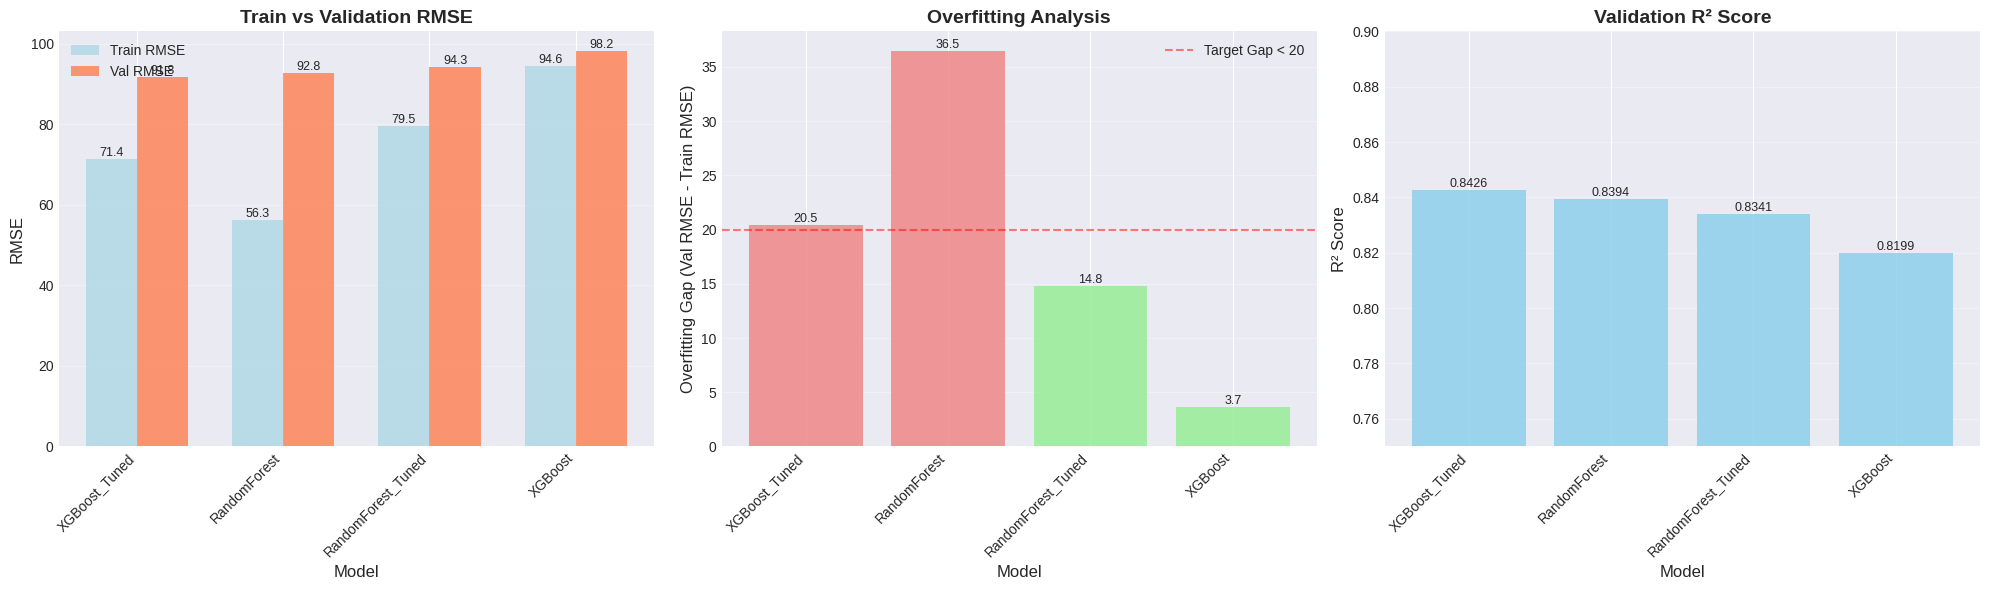


✓ Visualization saved to output/hyperparameter_tuning_comparison.png


In [12]:
# Visualize baseline vs tuned comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. RMSE comparison
models = all_results['model'].values
train_rmse_vals = all_results['train_rmse'].values
val_rmse_vals = all_results['val_rmse'].values

x = np.arange(len(models))
width = 0.35

bars1 = axes[0].bar(x - width/2, train_rmse_vals, width, label='Train RMSE', alpha=0.8, color='lightblue')
bars2 = axes[0].bar(x + width/2, val_rmse_vals, width, label='Val RMSE', alpha=0.8, color='coral')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title('Train vs Validation RMSE', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}',
                    ha='center', va='bottom', fontsize=9)

# 2. Overfitting gap
overfitting_gaps = all_results['overfitting_gap'].values
colors = ['lightcoral' if gap > 20 else 'lightgreen' for gap in overfitting_gaps]
bars = axes[1].bar(models, overfitting_gaps, alpha=0.8, color=colors)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Overfitting Gap (Val RMSE - Train RMSE)', fontsize=12)
axes[1].set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].axhline(y=20, color='red', linestyle='--', alpha=0.5, label='Target Gap < 20')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9)

# 3. R² Score
val_r2_vals = all_results['val_r2'].values
bars = axes[2].bar(models, val_r2_vals, alpha=0.8, color='skyblue')
axes[2].set_xlabel('Model', fontsize=12)
axes[2].set_ylabel('R² Score', fontsize=12)
axes[2].set_title('Validation R² Score', fontsize=14, fontweight='bold')
axes[2].set_xticklabels(models, rotation=45, ha='right')
axes[2].set_ylim([0.75, 0.90])
axes[2].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('output/hyperparameter_tuning_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to output/hyperparameter_tuning_comparison.png")


## 6. Final Model Selection and Predictions


In [ ]:
# Select the best performing model based on validation RMSE
best_model_name = all_results.iloc[0]['model']

if 'RandomForest' in best_model_name:
    final_model = rf_tuned
    model_type = 'RandomForest'
else:
    final_model = xgb_tuned
    model_type = 'XGBoost'

print(f"Selected Best Model: {best_model_name}")
print(f"{'='*60}")

# Retrain on full training data
print(f"\nRetraining on full training set...")
X_full_proc = preprocessor.transform(X_train_full)

if model_type == 'XGBoost':
    # For XGBoost, create a small validation set from full training for early stopping
    X_tr, X_vl, y_tr, y_vl = train_test_split(X_full_proc, y_train_full, test_size=0.1, random_state=42)
    final_model.fit(X_tr, y_tr, eval_set=[(X_vl, y_vl)], verbose=False)
else:
    final_model.fit(X_full_proc, y_train_full)

print(f"✓ Model retrained on {len(X_train_full):,} samples")

# Generate test predictions
print(f"\nGenerating predictions for test set...")
test_predictions = final_model.predict(X_test_proc)

# Ensure predictions are reasonable (within typical rating range)
test_predictions = np.clip(test_predictions, 500, 3000)

print(f"✓ Generated {len(test_predictions):,} predictions")


Selected Best Model: XGBoost_Tuned

Retraining on full training set...


✓ Model retrained on 100,820 samples

Generating predictions for test set...
✓ Generated 44,726 predictions

Prediction Statistics:
  Min:    1182.68
  Max:    2227.72
  Mean:   1909.64
  Median: 1934.08
  Std:    174.80


In [14]:
import pickle

# Save the best model
model_filename = f'output/best_model_{model_type.lower()}_tuned.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(final_model, f)
print(f"\n✓ Model saved to {model_filename}")

# Save the preprocessor
preprocessor_filename = 'output/preprocessor.pkl'
with open(preprocessor_filename, 'wb') as f:
    pickle.dump(preprocessor, f)
print(f"✓ Preprocessor saved to {preprocessor_filename}")

# Save predictions
predictions_df = pd.DataFrame({
    'rating': test_predictions
})
predictions_df.to_csv('output/test_predictions_tuned.csv', index=False)
print(f"✓ Predictions saved to output/test_predictions_tuned.csv")

# Save model comparison
all_results.to_csv('output/model_comparison_with_tuning.csv', index=False)
print(f"✓ Model comparison saved to output/model_comparison_with_tuning.csv")

print(f"\n{'='*60}")
print(f"TUNING COMPLETE!")
print(f"{'='*60}")
print(f"Best Model: {best_model_name}")
print(f"Validation RMSE: {all_results.iloc[0]['val_rmse']:.2f}")
print(f"Validation R²: {all_results.iloc[0]['val_r2']:.4f}")



✓ Model saved to output/best_model_xgboost_tuned.pkl
✓ Preprocessor saved to output/preprocessor.pkl
✓ Predictions saved to output/test_predictions_tuned.csv
✓ Model comparison saved to output/model_comparison_with_tuning.csv

TUNING COMPLETE!
Best Model: XGBoost_Tuned
Validation RMSE: 91.82
Validation R²: 0.8426


## 7. Baseline Model Comparison (for reference)

In [15]:
# Compare models
comparison_df = pd.DataFrame([rf_results, xgb_results])
comparison_df = comparison_df.sort_values('val_rmse')

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv('output/model_comparison.csv', index=False)
print("\n✓ Comparison saved to output/model_comparison.csv")


MODEL COMPARISON
       model  train_rmse  train_r2  val_rmse   val_r2  val_mape
RandomForest   56.294559  0.941060 92.752554 0.839373  3.348225
     XGBoost   94.553856  0.833721 98.224735 0.819860  3.731680

✓ Comparison saved to output/model_comparison.csv


## 8. Baseline Visualizations (for reference)

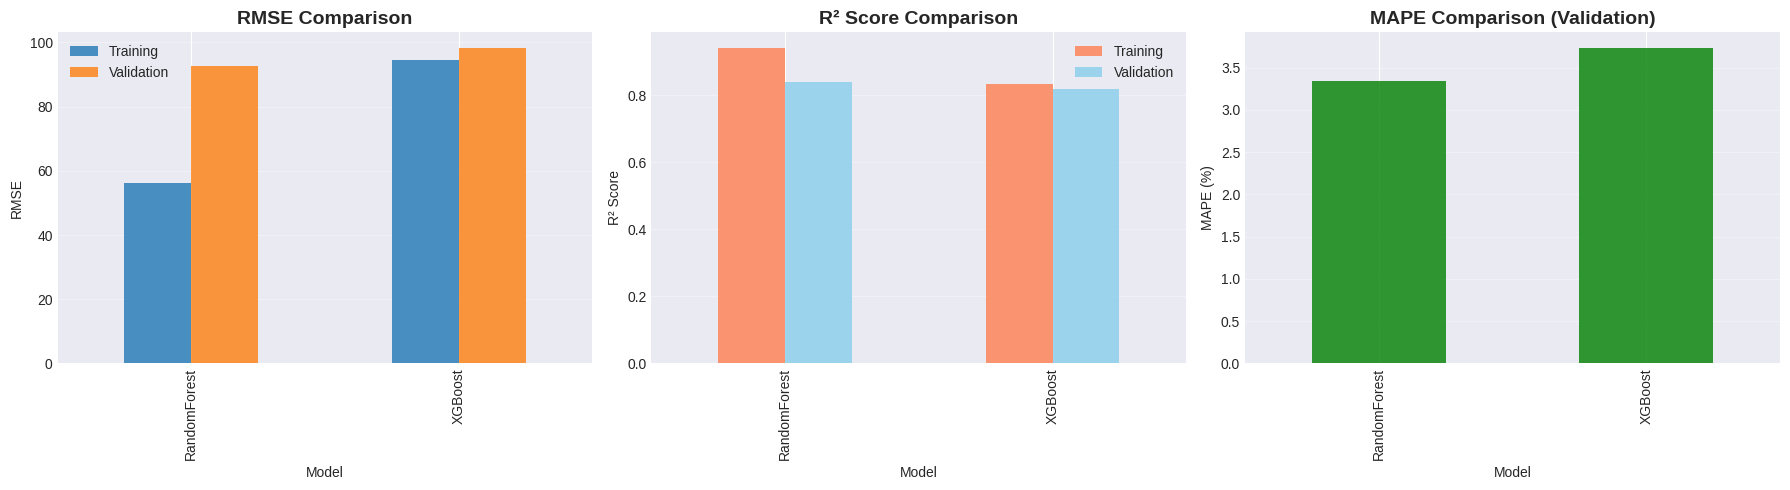

✓ Plot saved to output/model_comparison.png


In [16]:
# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE
comparison_df.plot(x='model', y=['train_rmse', 'val_rmse'], kind='bar', ax=axes[0], alpha=0.8)
axes[0].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('RMSE')
axes[0].set_xlabel('Model')
axes[0].legend(['Training', 'Validation'])
axes[0].grid(True, alpha=0.3, axis='y')

# R²
comparison_df.plot(x='model', y=['train_r2', 'val_r2'], kind='bar', ax=axes[1], alpha=0.8, color=['coral', 'skyblue'])
axes[1].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('R² Score')
axes[1].set_xlabel('Model')
axes[1].legend(['Training', 'Validation'])
axes[1].grid(True, alpha=0.3, axis='y')

# MAPE
comparison_df.plot(x='model', y='val_mape', kind='bar', ax=axes[2], alpha=0.8, color='green', legend=False)
axes[2].set_title('MAPE Comparison (Validation)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('MAPE (%)')
axes[2].set_xlabel('Model')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('output/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved to output/model_comparison.png")

## 9. Feature Importance (Baseline Models)


Top 20 Features (Average Importance):
   feature  rf_importance  xgb_importance  avg_importance
feature_48       0.278122        0.511858        0.394990
feature_49       0.199635        0.175797        0.187716
feature_11       0.047926        0.064641        0.056283
feature_27       0.072780        0.012260        0.042520
feature_16       0.042146        0.041110        0.041628
feature_32       0.023618        0.056937        0.040277
feature_39       0.047048        0.010971        0.029009
feature_51       0.051261        0.000000        0.025631
feature_31       0.025121        0.026011        0.025566
feature_25       0.029164        0.006821        0.017992
 feature_2       0.028861        0.006459        0.017660
 feature_7       0.029004        0.004127        0.016566
feature_38       0.018821        0.002197        0.010509
 feature_1       0.013224        0.000876        0.007050
 feature_9       0.006043        0.007157        0.006600
feature_17       0.007077        

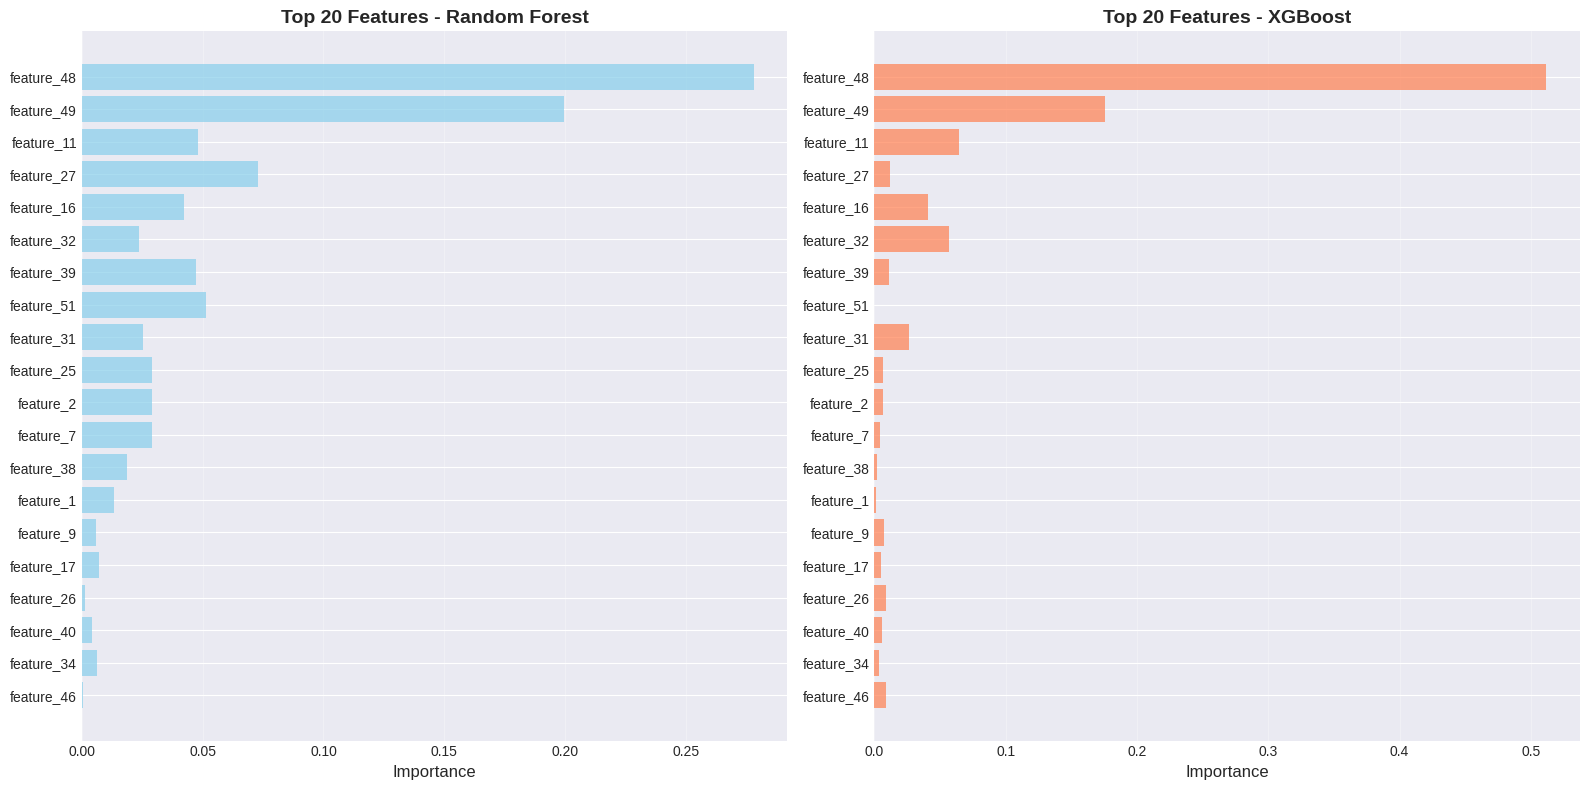


✓ Feature importance plots saved


In [17]:
# Random Forest Feature Importance
if hasattr(rf, 'feature_importances_'):
    try:
        feature_names = []
        if 'scaler' in preprocessor.named_transformers_:
            feature_names.extend(numeric_features)
        if 'encoder' in preprocessor.named_transformers_:
            ohe = preprocessor.named_transformers_['encoder']
            cat_names = ohe.get_feature_names_out(categorical_features).tolist()
            feature_names.extend(cat_names)
        
        if len(feature_names) != len(rf.feature_importances_):
            feature_names = [f'feature_{i}' for i in range(len(rf.feature_importances_))]
    except:
        feature_names = [f'feature_{i}' for i in range(len(rf.feature_importances_))]
    
    rf_importance = pd.DataFrame({
        'feature': feature_names,
        'rf_importance': rf.feature_importances_
    })

# XGBoost Feature Importance
if hasattr(xgb_model, 'feature_importances_'):
    xgb_importance = pd.DataFrame({
        'feature': feature_names,
        'xgb_importance': xgb_model.feature_importances_
    })

# Merge and compare
importance_df = rf_importance.merge(xgb_importance, on='feature')
importance_df['avg_importance'] = (importance_df['rf_importance'] + importance_df['xgb_importance']) / 2
importance_df = importance_df.sort_values('avg_importance', ascending=False)

print(f"\nTop 20 Features (Average Importance):")
print(importance_df.head(20)[['feature', 'rf_importance', 'xgb_importance', 'avg_importance']].to_string(index=False))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

top_20 = importance_df.head(20)
axes[0].barh(top_20['feature'][::-1], top_20['rf_importance'][::-1], alpha=0.7, color='skyblue')
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title('Top 20 Features - Random Forest', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

axes[1].barh(top_20['feature'][::-1], top_20['xgb_importance'][::-1], alpha=0.7, color='coral')
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('Top 20 Features - XGBoost', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('output/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance plots saved")

## 8. Generate Predictions with Best Model

In [18]:
# Select best model
best_model_name = comparison_df.iloc[0]['model']
print(f"Best model: {best_model_name}")
print(f"Validation RMSE: {comparison_df.iloc[0]['val_rmse']:.2f}")
print(f"Validation MAPE: {comparison_df.iloc[0]['val_mape']:.2f}%")
print(f"Validation R²: {comparison_df.iloc[0]['val_r2']:.4f}")

# Get the best model
if best_model_name == 'RandomForest':
    best_model = rf
else:
    best_model = xgb_model

# Generate predictions
print("\nGenerating predictions on test set...")
test_predictions = best_model.predict(X_test_proc)

print(f"\n✓ Generated {len(test_predictions)} predictions")
print(f"  Mean: {test_predictions.mean():.2f}")
print(f"  Std: {test_predictions.std():.2f}")
print(f"  Min: {test_predictions.min():.2f}")
print(f"  Max: {test_predictions.max():.2f}")

Best model: RandomForest
Validation RMSE: 92.75
Validation MAPE: 3.35%
Validation R²: 0.8394

Generating predictions on test set...

✓ Generated 44726 predictions
  Mean: 1918.02
  Std: 178.26
  Min: 1167.65
  Max: 2289.00


## 9. Save Results

In [19]:
# Save predictions
predictions_df = pd.DataFrame({'rating': test_predictions})
predictions_df.to_csv('output/predictions.csv', index=False)
print("✓ Predictions saved to output/predictions.csv")

# Save best model
import joblib
model_path = f'output/best_model_{best_model_name.lower()}.pkl'
joblib.dump(best_model, model_path)
print(f"✓ Best model saved to {model_path}")

✓ Predictions saved to output/predictions.csv


✓ Best model saved to output/best_model_randomforest.pkl


## 10. Summary

In [20]:
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)

print(f"\n📊 Models Trained: 2")
print(f"   • Random Forest")
print(f"   • XGBoost")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   • Validation RMSE: {comparison_df.iloc[0]['val_rmse']:.2f}")
print(f"   • Validation MAPE: {comparison_df.iloc[0]['val_mape']:.2f}%")
print(f"   • Validation R²: {comparison_df.iloc[0]['val_r2']:.4f}")

print(f"\n📁 Output Files:")
print(f"   • output/model_comparison.csv")
print(f"   • output/model_comparison.png")
print(f"   • output/feature_importance.png")
print(f"   • output/predictions.csv")
print(f"   • output/best_model_{best_model_name.lower()}.pkl")

print(f"\n✅ Training complete!")
print("="*60)


TRAINING SUMMARY

📊 Models Trained: 2
   • Random Forest
   • XGBoost

🏆 Best Model: RandomForest
   • Validation RMSE: 92.75
   • Validation MAPE: 3.35%
   • Validation R²: 0.8394

📁 Output Files:
   • output/model_comparison.csv
   • output/model_comparison.png
   • output/feature_importance.png
   • output/predictions.csv
   • output/best_model_randomforest.pkl

✅ Training complete!
